In [1]:
!nvidia-smi

Sat Nov 09 17:17:37 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.97       Driver Version: 440.97       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 166... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   36C    P3     9W /  N/A |    153MiB /  6144MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [9]:
#

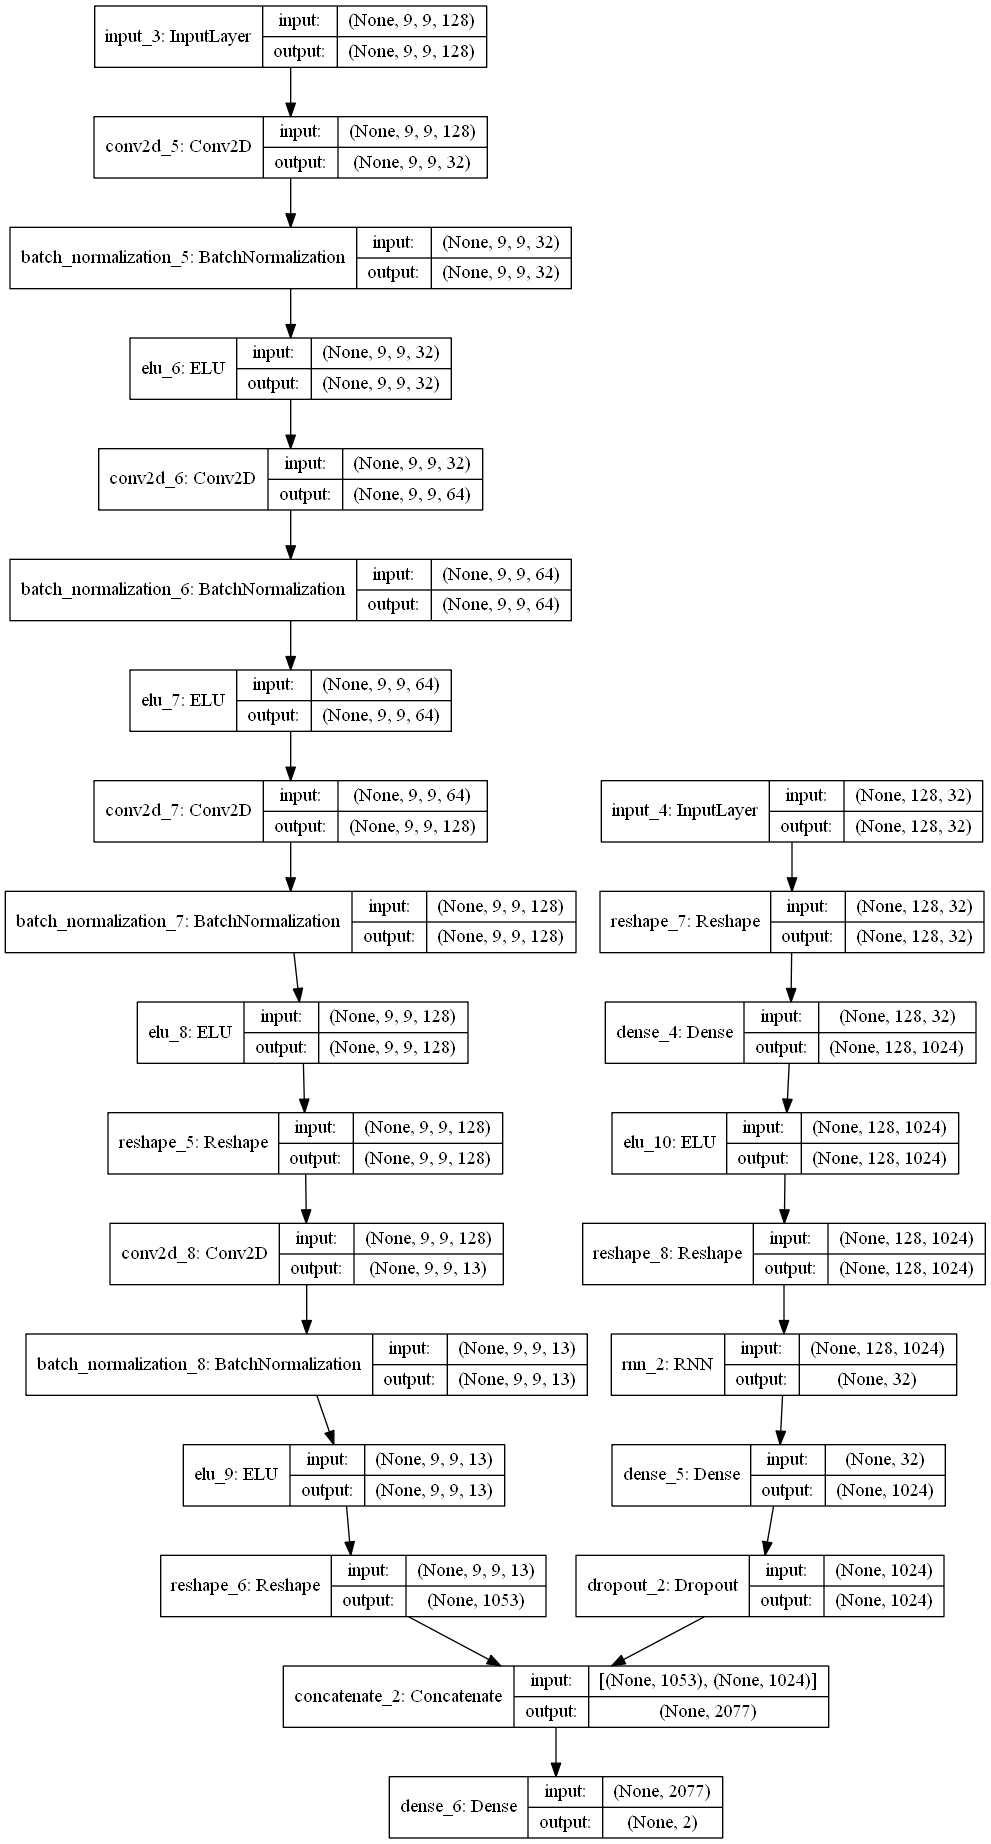

In [8]:
plot_model(model, to_file='full_model.png', show_shapes=True)

In [10]:
#

In [1]:
import sys
# import sklearn
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, roc_curve, auc
import os
import pandas as pd
import pickle
import tensorflow as tf
import numpy as np
import time
import math
import scipy.io as sio

from keras.layers import Conv2D, Dense, Flatten, ELU, BatchNormalization, LSTMCell, StackedRNNCells,\
    RNN, Permute, Dropout, Concatenate, Input, concatenate, Lambda, Reshape, Lambda

from keras import backend as K
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.merge import add
from keras.callbacks import TensorBoard

from keras import callbacks

from keras import regularizers

from keras.callbacks import ModelCheckpoint

import datetime

from keras.models import load_model
import matplotlib.pyplot as plt

import gc

Using TensorFlow backend.


In [2]:
data_files=[]
for i in range(1,33):
    if(1<=i<=9):
        s='s0'+str(i)
    else:
        s='s'+str(i)
    data_files.append(s)
print(len(data_files),data_files)

# emotions=['arousal','valence']

#baseline_preprocessing=['yes','no']
emotions=['dominance']

baseline_preprocessing=['yes']

32 ['s01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 's30', 's31', 's32']


In [3]:
# data_files=[data_files[0]]
data_files,emotions,baseline_preprocessing

(['s01',
  's02',
  's03',
  's04',
  's05',
  's06',
  's07',
  's08',
  's09',
  's10',
  's11',
  's12',
  's13',
  's14',
  's15',
  's16',
  's17',
  's18',
  's19',
  's20',
  's21',
  's22',
  's23',
  's24',
  's25',
  's26',
  's27',
  's28',
  's29',
  's30',
  's31',
  's32'],
 ['dominance'],
 ['yes'])

In [4]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)
        

# Example
createFolder('./data/dd')

In [5]:
data_files[:5]

['s01', 's02', 's03', 's04', 's05']

In [6]:
data_files=data_files[:5]
data_files

['s01', 's02', 's03', 's04', 's05']

In [7]:
np.random.seed(32)

window_size = 128

cnn_suffix ='.mat_win_128_cnn_dataset.pkl'
rnn_suffix ='.mat_win_128_rnn_dataset.pkl'
label_suffix ='.mat_win_128_labels.pkl'

for with_or_without in baseline_preprocessing:
    for arousal_or_valence in emotions:
        for data_file in data_files:
            
            gc.collect()
            
            print('---------------------------------------------------')
            print(with_or_without+' '+arousal_or_valence+' '+data_file)
            print('---------------------------------------------------\n')

            #data_file    ='s17'
            #arousal_or_valence = 'valence'
            #with_or_without = 'yes'

            dataset_dir = 'deap_shuffled_data/'+with_or_without+'_'+arousal_or_valence+'/'
            ###load training set
            try:
                with open(dataset_dir + data_file + cnn_suffix, "rb") as fp:
                    cnn_datasets = pickle.load(fp)
                with open(dataset_dir + data_file + rnn_suffix, "rb") as fp:
                    rnn_datasets = pickle.load(fp)
                with open(dataset_dir + data_file + label_suffix, "rb") as fp:
                    labels = pickle.load(fp)
                    labels = np.transpose(labels)
                    print("loaded shape:",labels.shape)
            except:
                continue
            lables_backup = labels

            print(cnn_datasets.shape)
            print(rnn_datasets.shape)
            print(labels.shape)

            #print("cnn_dataset shape before reshape:", np.shape(cnn_datasets))
            # cnn_datasets = cnn_datasets.reshape(len(cnn_datasets), window_size, 9,9, 1)
            #print("cnn_dataset shape after reshape:", np.shape(cnn_datasets))
            one_hot_labels = np.array(list(pd.get_dummies(labels)))

            labels = np.asarray(pd.get_dummies(labels), dtype=np.int8)

            print(labels.shape)
            # shuffle data
            index = np.array(range(0, len(labels)))
            np.random.shuffle(index)

            cnn_datasets   = cnn_datasets[index]
            rnn_datasets   = rnn_datasets[index]
            labels  = labels[index]

            print(cnn_datasets.shape)
            print(rnn_datasets.shape)
            print(labels.shape)

            #print("**********(" + time.asctime(time.localtime(time.time())) + ") Load and Split dataset End **********\n")
            #print("**********(" + time.asctime(time.localtime(time.time())) + ") Define parameters and functions Begin: **********\n")
            print('cnn_datasets.shape,rnn_datasets.shape,labels.shape : ',cnn_datasets.shape,rnn_datasets.shape,labels.shape)
            #important
            cnn_datasets=cnn_datasets.reshape(2400,9,9,-1)# imp
            print(cnn_datasets.shape)
            print('cnn_datasets.shape : ',cnn_datasets.shape)







            print('========================Train / Test Shapes==============================')



            fold=10
            curr_fold=0
            #for curr_fold in range(fold): # kernel dies
                
            #   print('curr_fold / fold : ',curr_fold,' / ',fold)


            max_acc_acc_list=[]

            max_acc_loss_list=[]


            min_loss_acc_list=[]

            min_loss_loss_list=[]

            fold_size = cnn_datasets.shape[0]//fold
            indexes_list = [i for i in range(len(cnn_datasets))]
            indexes = np.array(indexes_list)
            split_list = [i for i in range(curr_fold*fold_size,(curr_fold+1)*fold_size)]
            split = np.array(split_list)

            cnn_test = cnn_datasets[split] 
            labels_test = labels[split]
            rnn_test = rnn_datasets[split]

            split = np.array(list(set(indexes_list)^set(split_list)))

            cnn_train = cnn_datasets[split]
            rnn_train = rnn_datasets[split]
            labels_train = labels[split]

            # train_sample = labels_train.shape[0]
            # print("training examples:", train_sample)
            # test_sample = labels_test.shape[0]
            # print("test examples    :",test_sample)
            print(cnn_test.shape,rnn_test.shape,cnn_train.shape,rnn_train.shape)

            print('================================ DNN ============================================')

            input_cnn=Input(shape=(9,9,128))

            print('input_cnn: ',input_cnn.shape)

            conv1=Conv2D(32,
                          kernel_size=(4,4),
                          strides=(1,1),
                          padding='same',
                          input_shape=(9,9,128)
                         )(input_cnn)


            bn1=BatchNormalization()(conv1)

            elu1=ELU()(bn1)

            print('elu1: ',elu1.shape)
            #?,9,9,32
            conv2=Conv2D(64,
                          kernel_size=(4,4),
                          strides=(1,1),
                          padding='same'
                         )(elu1)

            bn2=BatchNormalization()(conv2)

            elu2=ELU()(bn2)

            print('elu2: ',elu2.shape)
            #?,9,9,64

            conv3=Conv2D(128,
                          kernel_size=(4,4),
                          strides=(1,1),
                          padding='same'
                         )(elu2)

            bn3=BatchNormalization()(conv3)

            elu3=ELU()(bn3)


            print('elu3: ',elu3.shape)
            #?,9,9,128

            # mc.add(Flatten())
            # mc.add(Lambda(lambda x:x,output_shape=(9,9,32*4*128)))
            # mc.add(Lambda(K.reshape((-1,9,9,32*4*128))))
            reshape1=Reshape((9,9,-1))(elu3)


            print('reshape1: ',reshape1.shape)
            #?,9,9,32*4*128

            conv4=Conv2D(13,#32*4*128,
                          kernel_size=(1,1),
                          strides=(1,1),
                          padding='same'
                         )(reshape1)

            bn4=BatchNormalization()(conv4)

            elu4=ELU()(bn4)


            print('elu4: ',elu4.shape)
            #?,9,9,13 #32*4*128

            # mc.add(Flatten())

            # mc.add(Lambda(lambda x:x,output_shape=([13*9*9])))
            # mc.add(Lambda(K.reshape((None,13*9*9))))
            reshape2=Reshape(([13*9*9]))(elu4)


            print('reshape2: ',reshape2.shape)




            cnn_out_fuse=reshape2


            # cube=K.reshape(e3,(-1,9,9,32*4*128))#(e3)


            # flat=K.reshape(e4,(-1,13*9*9))#(e4) #1053

            # rnn_in=K.placeholder(shape=(None,128,32))
            # rnn_in=tf.convert_to_tensor(rnn_datasets,dtype='float32')


            # rnn_in.get_shape().as_list()

            # rnn_in=K.placeholder(shape=(None,128,32))
            # rnn_in_flat=K.reshape(rnn_in,[-1,32])

            # print('rnn_in ',rnn_in.shape)

            input_rnn=Input(shape=(128,32))
            print('input_rnn',input_rnn.shape)

            rnn_in_flat=Reshape((-1,32))(input_rnn)
            print('rnn_in_flat',rnn_in_flat.shape)
            # rnn_in_flat = Lambda(lambda x:x[:,0])(input_rnn)

            # rnn_fc_in1 =Dense(32)(rnn_in_flat)
            rnn_fc_in1 =Dense(1024)(rnn_in_flat)
            rnn_fc_in=ELU()(rnn_fc_in1)
            print('rnn_fc_in',rnn_fc_in.shape)

            # rnn_fc_in =Dense(1024)(input_rnn)

            # lstm_in=Reshape((-1,128,1024))(rnn_fc_in)
            lstm_in=Reshape((-1,1024))(rnn_fc_in)
            print('lstm_in',lstm_in.shape)

            cells=[]

            for i in range(2):
                cell=LSTMCell(32,unit_forget_bias=True,dropout=0.5)#'forget_bias'=1.0,'state_is_tuple'=True
                cells.append(cell)
            #     print(cell.shape)

            # lstm_cell=StackedRNNCells(cells)
            lstm_cell=RNN(cells)(lstm_in)
            # print(lstm_cell.shape)
            # op,states=RNN(cells)(lstm_in)
            print('lstm_cell',lstm_cell.shape)
            # output=K.transpose_shape((1,0,2),lstm_cell)
            # output=Permute((1,0,2))(lstm_cell)
            # output.reshape()
            output=lstm_cell
            print('output',output.shape)
            rnn_output=output[-1]
            # rnn_output

            print('rnn_output',rnn_output.shape)
            # shape_rnn_out=rnn_output.get_shape().as_list()
            lstm_fc_out=Dense(1024)(output)#shape_rnn_out[1]

            print('lstm_fc_out',lstm_fc_out.shape)


            # lstm_fc_out_2=Dense(1053)(lstm_fc_out)#shape_rnn_out[1]



            lstm_fc_drop=Dropout(0.5)(lstm_fc_out)
            # lstm_fc_drop
            print('lstm_fc_drop',lstm_fc_drop.shape)

            # fuse_cnn_rnn=add([cnn_out_fuse,lstm_fc_drop])

            fuse_cnn_rnn=concatenate([cnn_out_fuse,lstm_fc_drop])
            print('fuse_cnn_rnn ',fuse_cnn_rnn.shape)
            y=Dense(2,activation='softmax')(fuse_cnn_rnn) ## ,activity_regularizer=regularizers.l2(0.5)
            print(y.shape)
            y_pred=K.argmax(y,1)
            # y_pred=K.argmax(K.softmax(y))
            # y_posi=K.softmax(y)
            print('y ',y)


            directory_le007a='./lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file
            try:
                if not os.path.exists(directory_le007a):
                    os.makedirs(directory_le007a)
            except OSError:
                print ('Error: Creating directory. ' +  directory_le007a)



            model=Model(inputs=[input_cnn,input_rnn],outputs=y)
            model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

            print('Model : ',with_or_without+'_'+arousal_or_valence+'_'+data_file+'_'+str(curr_fold)+'_fold')
            print(model.summary())

            m_val_acc=ModelCheckpoint('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'max_acc_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.h5',monitor='val_accuracy',mode='max',verbose=1,save_best_only=True)
            m_val_loss=ModelCheckpoint('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'min_loss_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.h5',monitor='val_loss',mode='min',verbose=1,save_best_only=True)


            tb_log_dir='lightningedge007a_results\\'+with_or_without+'\\'+arousal_or_valence+'\\'+data_file+'\\'+'logs_'+with_or_without+'_'+arousal_or_valence+'_'+data_file
            #tb_log_dir='lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'logs_'+with_or_without+'_'+arousal_or_valence+'_'+data_file

            createFolder(tb_log_dir)


            #log_dir='lightningedge007a_results\\'+with_or_without+'\\'+arousal_or_valence+'\\'+data_file+'\\'+'logs_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'_'+str(curr_fold)+'_fold\\' #datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
            tensorboard_callback = callbacks.TensorBoard(log_dir=tb_log_dir)#, histogram_freq=1)

            plotpicture=plot_model(model, to_file='lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'model_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.png', show_shapes=True)

            
            
            gc.collect()
            
            

            history=model.fit([cnn_train,rnn_train],labels_train,batch_size=128,epochs=50,callbacks=[tensorboard_callback,m_val_acc,m_val_loss],validation_split=0.2)


            #Plot values
            plt.plot(history.history['accuracy'])
            plt.plot(history.history['val_accuracy'])
            plt.title('max_acc_'+with_or_without+'_'+arousal_or_valence+'_'+data_file)
            plt.ylabel('Accuracy')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Validation'], loc='upper right',bbox_to_anchor=(1.3,1))
            plt.savefig('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'max_acc_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.png',bbox_inches='tight')
            #plt.show()
            plt.close()


            # Plot training & validation loss values
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('min_loss_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'_'+str(curr_fold)+'_fold')
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Validation'], loc='upper right',bbox_to_anchor=(1.3,1))
            plt.savefig('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'min_loss_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.png',bbox_inches='tight')
            #plt.show()
            plt.close()

            vam=load_model('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'max_acc_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.h5')
            vlm=load_model('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'min_loss_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.h5')
            # pred_labels=vam()
            vam_eval=vam.evaluate([cnn_test,rnn_test],labels_test)
            print('max acc: ',vam_eval)
            vlm_eval=vlm.evaluate([cnn_test,rnn_test],labels_test)
            print('min loss: ',vlm_eval)


            max_acc_acc_list.append(vam_eval[1])

            max_acc_loss_list.append(vam_eval[0])


            min_loss_acc_list.append(vlm_eval[1])

            min_loss_loss_list.append(vlm_eval[0])

            pickle.dump(max_acc_acc_list,open('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'max_acc_acc_list_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.pkl','wb'))

            pickle.dump(max_acc_loss_list,open('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'max_acc_loss_list_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.pkl','wb'))


            pickle.dump(min_loss_acc_list,open('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'min_loss_acc_list_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.pkl','wb'))

            pickle.dump(min_loss_loss_list,open('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'min_loss_loss_list_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.pkl','wb'))
            
            
            gc.collect()


---------------------------------------------------
yes dominance s01
---------------------------------------------------

loaded shape: (2400,)
(2400, 128, 9, 9)
(2400, 128, 32)
(2400,)
(2400, 2)
(2400, 128, 9, 9)
(2400, 128, 32)
(2400, 2)
cnn_datasets.shape,rnn_datasets.shape,labels.shape :  (2400, 128, 9, 9) (2400, 128, 32) (2400, 2)
(2400, 9, 9, 128)
cnn_datasets.shape :  (2400, 9, 9, 128)
========================Train / Test Shapes==============================
(240, 9, 9, 128) (240, 128, 32) (2160, 9, 9, 128) (2160, 128, 32)
================================ DNN ============================================
input_cnn:  (None, 9, 9, 128)
elu1:  (None, 9, 9, 32)
elu2:  (None, 9, 9, 64)
elu3:  (None, 9, 9, 128)
reshape1:  (None, 9, 9, None)
elu4:  (None, 9, 9, 13)
reshape2:  (None, 1053)
input_rnn (None, 128, 32)
rnn_in_flat (None, None, 32)
rnn_fc_in (None, 128, 1024)
lstm_in (None, None, 1024)
lstm_cell (None, 32)
output (None, 32)
rnn_output (32,)
lstm_fc_out (None, 1024)
lstm_fc_d

C:\Users\ABHISHEK_VERMA\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (10.725219). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


1728/1728 [==============================] - 30s 17ms/step - loss: 0.2881 - accuracy: 0.8756 - val_loss: 0.1333 - val_accuracy: 0.9630

Epoch 00001: val_accuracy improved from -inf to 0.96296, saving model to lightningedge007a_results/yes/dominance/s01/max_acc_yes_dominance_s01.h5

Epoch 00001: val_loss improved from inf to 0.13327, saving model to lightningedge007a_results/yes/dominance/s01/min_loss_yes_dominance_s01.h5
Epoch 2/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.0276 - accuracy: 0.9942 - val_loss: 0.0694 - val_accuracy: 0.9815

Epoch 00002: val_accuracy improved from 0.96296 to 0.98148, saving model to lightningedge007a_results/yes/dominance/s01/max_acc_yes_dominance_s01.h5

Epoch 00002: val_loss improved from 0.13327 to 0.06937, saving model to lightningedge007a_results/yes/dominance/s01/min_loss_yes_dominance_s01.h5
Epoch 3/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.0460 - val_accurac

1728/1728 [==============================] - 3s 2ms/step - loss: 1.3362e-04 - accuracy: 1.0000 - val_loss: 0.0076 - val_accuracy: 1.0000

Epoch 00023: val_accuracy did not improve from 1.00000

Epoch 00023: val_loss improved from 0.00788 to 0.00761, saving model to lightningedge007a_results/yes/dominance/s01/min_loss_yes_dominance_s01.h5
Epoch 24/50
1728/1728 [==============================] - 3s 2ms/step - loss: 1.2587e-04 - accuracy: 1.0000 - val_loss: 0.0074 - val_accuracy: 1.0000

Epoch 00024: val_accuracy did not improve from 1.00000

Epoch 00024: val_loss improved from 0.00761 to 0.00738, saving model to lightningedge007a_results/yes/dominance/s01/min_loss_yes_dominance_s01.h5
Epoch 25/50
1728/1728 [==============================] - 3s 2ms/step - loss: 1.1727e-04 - accuracy: 1.0000 - val_loss: 0.0072 - val_accuracy: 1.0000

Epoch 00025: val_accuracy did not improve from 1.00000

Epoch 00025: val_loss improved from 0.00738 to 0.00717, saving model to lightningedge007a_results/yes/


Epoch 00046: val_accuracy did not improve from 1.00000

Epoch 00046: val_loss improved from 0.00499 to 0.00496, saving model to lightningedge007a_results/yes/dominance/s01/min_loss_yes_dominance_s01.h5
Epoch 47/50
1728/1728 [==============================] - 3s 2ms/step - loss: 4.2927e-05 - accuracy: 1.0000 - val_loss: 0.0049 - val_accuracy: 1.0000

Epoch 00047: val_accuracy did not improve from 1.00000

Epoch 00047: val_loss improved from 0.00496 to 0.00490, saving model to lightningedge007a_results/yes/dominance/s01/min_loss_yes_dominance_s01.h5
Epoch 48/50
1728/1728 [==============================] - 3s 2ms/step - loss: 4.2023e-05 - accuracy: 1.0000 - val_loss: 0.0049 - val_accuracy: 1.0000

Epoch 00048: val_accuracy did not improve from 1.00000

Epoch 00048: val_loss improved from 0.00490 to 0.00488, saving model to lightningedge007a_results/yes/dominance/s01/min_loss_yes_dominance_s01.h5
Epoch 49/50
1728/1728 [==============================] - 3s 2ms/step - loss: 4.0703e-05 - acc

Train on 1728 samples, validate on 432 samples
Epoch 1/50
 256/1728 [===>..........................] - ETA: 10s - loss: 1.0684 - accuracy: 0.5898

C:\Users\ABHISHEK_VERMA\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (9.924531). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


1728/1728 [==============================] - 24s 14ms/step - loss: 0.6670 - accuracy: 0.7633 - val_loss: 0.3603 - val_accuracy: 0.8542

Epoch 00001: val_accuracy improved from -inf to 0.85417, saving model to lightningedge007a_results/yes/dominance/s02/max_acc_yes_dominance_s02.h5

Epoch 00001: val_loss improved from inf to 0.36030, saving model to lightningedge007a_results/yes/dominance/s02/min_loss_yes_dominance_s02.h5
Epoch 2/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.2026 - accuracy: 0.9242 - val_loss: 0.2945 - val_accuracy: 0.8727

Epoch 00002: val_accuracy improved from 0.85417 to 0.87269, saving model to lightningedge007a_results/yes/dominance/s02/max_acc_yes_dominance_s02.h5

Epoch 00002: val_loss improved from 0.36030 to 0.29451, saving model to lightningedge007a_results/yes/dominance/s02/min_loss_yes_dominance_s02.h5
Epoch 3/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.1148 - accuracy: 0.9612 - val_loss: 0.2304 - val_accurac

1728/1728 [==============================] - 3s 2ms/step - loss: 4.2688e-04 - accuracy: 1.0000 - val_loss: 0.2047 - val_accuracy: 0.9398

Epoch 00027: val_accuracy did not improve from 0.94676

Epoch 00027: val_loss did not improve from 0.16598
Epoch 28/50
1728/1728 [==============================] - 3s 2ms/step - loss: 3.9824e-04 - accuracy: 1.0000 - val_loss: 0.2035 - val_accuracy: 0.9421

Epoch 00028: val_accuracy did not improve from 0.94676

Epoch 00028: val_loss did not improve from 0.16598
Epoch 29/50
1728/1728 [==============================] - 3s 2ms/step - loss: 3.7193e-04 - accuracy: 1.0000 - val_loss: 0.2062 - val_accuracy: 0.9421

Epoch 00029: val_accuracy did not improve from 0.94676

Epoch 00029: val_loss did not improve from 0.16598
Epoch 30/50
1728/1728 [==============================] - 3s 2ms/step - loss: 3.5134e-04 - accuracy: 1.0000 - val_loss: 0.2060 - val_accuracy: 0.9444

Epoch 00030: val_accuracy did not improve from 0.94676

Epoch 00030: val_loss did not impro

Train on 1728 samples, validate on 432 samples
Epoch 1/50
 256/1728 [===>..........................] - ETA: 11s - loss: 0.8710 - accuracy: 0.6211

C:\Users\ABHISHEK_VERMA\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (10.480031). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


1728/1728 [==============================] - 26s 15ms/step - loss: 0.4168 - accuracy: 0.8310 - val_loss: 0.2007 - val_accuracy: 0.9352

Epoch 00001: val_accuracy improved from -inf to 0.93519, saving model to lightningedge007a_results/yes/dominance/s03/max_acc_yes_dominance_s03.h5

Epoch 00001: val_loss improved from inf to 0.20073, saving model to lightningedge007a_results/yes/dominance/s03/min_loss_yes_dominance_s03.h5
Epoch 2/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.0874 - accuracy: 0.9728 - val_loss: 0.1467 - val_accuracy: 0.9537

Epoch 00002: val_accuracy improved from 0.93519 to 0.95370, saving model to lightningedge007a_results/yes/dominance/s03/max_acc_yes_dominance_s03.h5

Epoch 00002: val_loss improved from 0.20073 to 0.14669, saving model to lightningedge007a_results/yes/dominance/s03/min_loss_yes_dominance_s03.h5
Epoch 3/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.0331 - accuracy: 0.9913 - val_loss: 0.0815 - val_accurac


Epoch 00025: val_accuracy did not improve from 0.98843

Epoch 00025: val_loss did not improve from 0.04536
Epoch 26/50
1728/1728 [==============================] - 3s 2ms/step - loss: 2.5085e-04 - accuracy: 1.0000 - val_loss: 0.0457 - val_accuracy: 0.9838

Epoch 00026: val_accuracy did not improve from 0.98843

Epoch 00026: val_loss did not improve from 0.04536
Epoch 27/50
1728/1728 [==============================] - 3s 2ms/step - loss: 2.3995e-04 - accuracy: 1.0000 - val_loss: 0.0455 - val_accuracy: 0.9838

Epoch 00027: val_accuracy did not improve from 0.98843

Epoch 00027: val_loss did not improve from 0.04536
Epoch 28/50
1728/1728 [==============================] - 3s 2ms/step - loss: 2.2514e-04 - accuracy: 1.0000 - val_loss: 0.0454 - val_accuracy: 0.9838

Epoch 00028: val_accuracy did not improve from 0.98843

Epoch 00028: val_loss did not improve from 0.04536
Epoch 29/50
1728/1728 [==============================] - 3s 2ms/step - loss: 2.1068e-04 - accuracy: 1.0000 - val_loss: 0.

Train on 1728 samples, validate on 432 samples
Epoch 1/50
 256/1728 [===>..........................] - ETA: 10s - loss: 0.8541 - accuracy: 0.6016

C:\Users\ABHISHEK_VERMA\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (11.239255). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


1728/1728 [==============================] - 27s 16ms/step - loss: 0.5318 - accuracy: 0.7928 - val_loss: 0.3629 - val_accuracy: 0.8542

Epoch 00001: val_accuracy improved from -inf to 0.85417, saving model to lightningedge007a_results/yes/dominance/s04/max_acc_yes_dominance_s04.h5

Epoch 00001: val_loss improved from inf to 0.36285, saving model to lightningedge007a_results/yes/dominance/s04/min_loss_yes_dominance_s04.h5
Epoch 2/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.1626 - accuracy: 0.9375 - val_loss: 0.2658 - val_accuracy: 0.9051

Epoch 00002: val_accuracy improved from 0.85417 to 0.90509, saving model to lightningedge007a_results/yes/dominance/s04/max_acc_yes_dominance_s04.h5

Epoch 00002: val_loss improved from 0.36285 to 0.26576, saving model to lightningedge007a_results/yes/dominance/s04/min_loss_yes_dominance_s04.h5
Epoch 3/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.0793 - accuracy: 0.9792 - val_loss: 0.2122 - val_accurac


Epoch 00026: val_accuracy did not improve from 0.95833

Epoch 00026: val_loss did not improve from 0.11242
Epoch 27/50
1728/1728 [==============================] - 3s 2ms/step - loss: 3.3190e-04 - accuracy: 1.0000 - val_loss: 0.1304 - val_accuracy: 0.9583

Epoch 00027: val_accuracy did not improve from 0.95833

Epoch 00027: val_loss did not improve from 0.11242
Epoch 28/50
1728/1728 [==============================] - 3s 2ms/step - loss: 3.1164e-04 - accuracy: 1.0000 - val_loss: 0.1305 - val_accuracy: 0.9583

Epoch 00028: val_accuracy did not improve from 0.95833

Epoch 00028: val_loss did not improve from 0.11242
Epoch 29/50
1728/1728 [==============================] - 3s 2ms/step - loss: 2.9271e-04 - accuracy: 1.0000 - val_loss: 0.1300 - val_accuracy: 0.9583

Epoch 00029: val_accuracy did not improve from 0.95833

Epoch 00029: val_loss did not improve from 0.11242
Epoch 30/50
1728/1728 [==============================] - 3s 2ms/step - loss: 2.6967e-04 - accuracy: 1.0000 - val_loss: 0.

Train on 1728 samples, validate on 432 samples
Epoch 1/50
 256/1728 [===>..........................] - ETA: 10s - loss: 1.4243 - accuracy: 0.4961

C:\Users\ABHISHEK_VERMA\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (10.630046). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


1728/1728 [==============================] - 26s 15ms/step - loss: 0.6511 - accuracy: 0.7517 - val_loss: 0.3073 - val_accuracy: 0.8843

Epoch 00001: val_accuracy improved from -inf to 0.88426, saving model to lightningedge007a_results/yes/dominance/s05/max_acc_yes_dominance_s05.h5

Epoch 00001: val_loss improved from inf to 0.30729, saving model to lightningedge007a_results/yes/dominance/s05/min_loss_yes_dominance_s05.h5
Epoch 2/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.1532 - accuracy: 0.9381 - val_loss: 0.1845 - val_accuracy: 0.9537

Epoch 00002: val_accuracy improved from 0.88426 to 0.95370, saving model to lightningedge007a_results/yes/dominance/s05/max_acc_yes_dominance_s05.h5

Epoch 00002: val_loss improved from 0.30729 to 0.18454, saving model to lightningedge007a_results/yes/dominance/s05/min_loss_yes_dominance_s05.h5
Epoch 3/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.0733 - accuracy: 0.9815 - val_loss: 0.1566 - val_accurac

In [5]:
data_files[5:10]

['s06', 's07', 's08', 's09', 's10']

In [6]:
data_files=data_files[5:10]
data_files

['s06', 's07', 's08', 's09', 's10']

In [7]:
np.random.seed(32)

window_size = 128

cnn_suffix ='.mat_win_128_cnn_dataset.pkl'
rnn_suffix ='.mat_win_128_rnn_dataset.pkl'
label_suffix ='.mat_win_128_labels.pkl'

for with_or_without in baseline_preprocessing:
    for arousal_or_valence in emotions:
        for data_file in data_files:
            
            gc.collect()
            
            print('---------------------------------------------------')
            print(with_or_without+' '+arousal_or_valence+' '+data_file)
            print('---------------------------------------------------\n')

            #data_file    ='s17'
            #arousal_or_valence = 'valence'
            #with_or_without = 'yes'

            dataset_dir = 'deap_shuffled_data/'+with_or_without+'_'+arousal_or_valence+'/'
            ###load training set
            try:
                with open(dataset_dir + data_file + cnn_suffix, "rb") as fp:
                    cnn_datasets = pickle.load(fp)
                with open(dataset_dir + data_file + rnn_suffix, "rb") as fp:
                    rnn_datasets = pickle.load(fp)
                with open(dataset_dir + data_file + label_suffix, "rb") as fp:
                    labels = pickle.load(fp)
                    labels = np.transpose(labels)
                    print("loaded shape:",labels.shape)
            except:
                continue
            lables_backup = labels

            print(cnn_datasets.shape)
            print(rnn_datasets.shape)
            print(labels.shape)

            #print("cnn_dataset shape before reshape:", np.shape(cnn_datasets))
            # cnn_datasets = cnn_datasets.reshape(len(cnn_datasets), window_size, 9,9, 1)
            #print("cnn_dataset shape after reshape:", np.shape(cnn_datasets))
            one_hot_labels = np.array(list(pd.get_dummies(labels)))

            labels = np.asarray(pd.get_dummies(labels), dtype=np.int8)

            print(labels.shape)
            # shuffle data
            index = np.array(range(0, len(labels)))
            np.random.shuffle(index)

            cnn_datasets   = cnn_datasets[index]
            rnn_datasets   = rnn_datasets[index]
            labels  = labels[index]

            print(cnn_datasets.shape)
            print(rnn_datasets.shape)
            print(labels.shape)

            #print("**********(" + time.asctime(time.localtime(time.time())) + ") Load and Split dataset End **********\n")
            #print("**********(" + time.asctime(time.localtime(time.time())) + ") Define parameters and functions Begin: **********\n")
            print('cnn_datasets.shape,rnn_datasets.shape,labels.shape : ',cnn_datasets.shape,rnn_datasets.shape,labels.shape)
            #important
            cnn_datasets=cnn_datasets.reshape(2400,9,9,-1)# imp
            print(cnn_datasets.shape)
            print('cnn_datasets.shape : ',cnn_datasets.shape)







            print('========================Train / Test Shapes==============================')



            fold=10
            curr_fold=0
            #for curr_fold in range(fold): # kernel dies
                
            #   print('curr_fold / fold : ',curr_fold,' / ',fold)


            max_acc_acc_list=[]

            max_acc_loss_list=[]


            min_loss_acc_list=[]

            min_loss_loss_list=[]

            fold_size = cnn_datasets.shape[0]//fold
            indexes_list = [i for i in range(len(cnn_datasets))]
            indexes = np.array(indexes_list)
            split_list = [i for i in range(curr_fold*fold_size,(curr_fold+1)*fold_size)]
            split = np.array(split_list)

            cnn_test = cnn_datasets[split] 
            labels_test = labels[split]
            rnn_test = rnn_datasets[split]

            split = np.array(list(set(indexes_list)^set(split_list)))

            cnn_train = cnn_datasets[split]
            rnn_train = rnn_datasets[split]
            labels_train = labels[split]

            # train_sample = labels_train.shape[0]
            # print("training examples:", train_sample)
            # test_sample = labels_test.shape[0]
            # print("test examples    :",test_sample)
            print(cnn_test.shape,rnn_test.shape,cnn_train.shape,rnn_train.shape)

            print('================================ DNN ============================================')

            input_cnn=Input(shape=(9,9,128))

            print('input_cnn: ',input_cnn.shape)

            conv1=Conv2D(32,
                          kernel_size=(4,4),
                          strides=(1,1),
                          padding='same',
                          input_shape=(9,9,128)
                         )(input_cnn)


            bn1=BatchNormalization()(conv1)

            elu1=ELU()(bn1)

            print('elu1: ',elu1.shape)
            #?,9,9,32
            conv2=Conv2D(64,
                          kernel_size=(4,4),
                          strides=(1,1),
                          padding='same'
                         )(elu1)

            bn2=BatchNormalization()(conv2)

            elu2=ELU()(bn2)

            print('elu2: ',elu2.shape)
            #?,9,9,64

            conv3=Conv2D(128,
                          kernel_size=(4,4),
                          strides=(1,1),
                          padding='same'
                         )(elu2)

            bn3=BatchNormalization()(conv3)

            elu3=ELU()(bn3)


            print('elu3: ',elu3.shape)
            #?,9,9,128

            # mc.add(Flatten())
            # mc.add(Lambda(lambda x:x,output_shape=(9,9,32*4*128)))
            # mc.add(Lambda(K.reshape((-1,9,9,32*4*128))))
            reshape1=Reshape((9,9,-1))(elu3)


            print('reshape1: ',reshape1.shape)
            #?,9,9,32*4*128

            conv4=Conv2D(13,#32*4*128,
                          kernel_size=(1,1),
                          strides=(1,1),
                          padding='same'
                         )(reshape1)

            bn4=BatchNormalization()(conv4)

            elu4=ELU()(bn4)


            print('elu4: ',elu4.shape)
            #?,9,9,13 #32*4*128

            # mc.add(Flatten())

            # mc.add(Lambda(lambda x:x,output_shape=([13*9*9])))
            # mc.add(Lambda(K.reshape((None,13*9*9))))
            reshape2=Reshape(([13*9*9]))(elu4)


            print('reshape2: ',reshape2.shape)




            cnn_out_fuse=reshape2


            # cube=K.reshape(e3,(-1,9,9,32*4*128))#(e3)


            # flat=K.reshape(e4,(-1,13*9*9))#(e4) #1053

            # rnn_in=K.placeholder(shape=(None,128,32))
            # rnn_in=tf.convert_to_tensor(rnn_datasets,dtype='float32')


            # rnn_in.get_shape().as_list()

            # rnn_in=K.placeholder(shape=(None,128,32))
            # rnn_in_flat=K.reshape(rnn_in,[-1,32])

            # print('rnn_in ',rnn_in.shape)

            input_rnn=Input(shape=(128,32))
            print('input_rnn',input_rnn.shape)

            rnn_in_flat=Reshape((-1,32))(input_rnn)
            print('rnn_in_flat',rnn_in_flat.shape)
            # rnn_in_flat = Lambda(lambda x:x[:,0])(input_rnn)

            # rnn_fc_in1 =Dense(32)(rnn_in_flat)
            rnn_fc_in1 =Dense(1024)(rnn_in_flat)
            rnn_fc_in=ELU()(rnn_fc_in1)
            print('rnn_fc_in',rnn_fc_in.shape)

            # rnn_fc_in =Dense(1024)(input_rnn)

            # lstm_in=Reshape((-1,128,1024))(rnn_fc_in)
            lstm_in=Reshape((-1,1024))(rnn_fc_in)
            print('lstm_in',lstm_in.shape)

            cells=[]

            for i in range(2):
                cell=LSTMCell(32,unit_forget_bias=True,dropout=0.5)#'forget_bias'=1.0,'state_is_tuple'=True
                cells.append(cell)
            #     print(cell.shape)

            # lstm_cell=StackedRNNCells(cells)
            lstm_cell=RNN(cells)(lstm_in)
            # print(lstm_cell.shape)
            # op,states=RNN(cells)(lstm_in)
            print('lstm_cell',lstm_cell.shape)
            # output=K.transpose_shape((1,0,2),lstm_cell)
            # output=Permute((1,0,2))(lstm_cell)
            # output.reshape()
            output=lstm_cell
            print('output',output.shape)
            rnn_output=output[-1]
            # rnn_output

            print('rnn_output',rnn_output.shape)
            # shape_rnn_out=rnn_output.get_shape().as_list()
            lstm_fc_out=Dense(1024)(output)#shape_rnn_out[1]

            print('lstm_fc_out',lstm_fc_out.shape)


            # lstm_fc_out_2=Dense(1053)(lstm_fc_out)#shape_rnn_out[1]



            lstm_fc_drop=Dropout(0.5)(lstm_fc_out)
            # lstm_fc_drop
            print('lstm_fc_drop',lstm_fc_drop.shape)

            # fuse_cnn_rnn=add([cnn_out_fuse,lstm_fc_drop])

            fuse_cnn_rnn=concatenate([cnn_out_fuse,lstm_fc_drop])
            print('fuse_cnn_rnn ',fuse_cnn_rnn.shape)
            y=Dense(2,activation='softmax')(fuse_cnn_rnn) ## ,activity_regularizer=regularizers.l2(0.5)
            print(y.shape)
            y_pred=K.argmax(y,1)
            # y_pred=K.argmax(K.softmax(y))
            # y_posi=K.softmax(y)
            print('y ',y)


            directory_le007a='./lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file
            try:
                if not os.path.exists(directory_le007a):
                    os.makedirs(directory_le007a)
            except OSError:
                print ('Error: Creating directory. ' +  directory_le007a)



            model=Model(inputs=[input_cnn,input_rnn],outputs=y)
            model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

            print('Model : ',with_or_without+'_'+arousal_or_valence+'_'+data_file+'_'+str(curr_fold)+'_fold')
            print(model.summary())

            m_val_acc=ModelCheckpoint('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'max_acc_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.h5',monitor='val_accuracy',mode='max',verbose=1,save_best_only=True)
            m_val_loss=ModelCheckpoint('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'min_loss_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.h5',monitor='val_loss',mode='min',verbose=1,save_best_only=True)


            tb_log_dir='lightningedge007a_results\\'+with_or_without+'\\'+arousal_or_valence+'\\'+data_file+'\\'+'logs_'+with_or_without+'_'+arousal_or_valence+'_'+data_file
            #tb_log_dir='lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'logs_'+with_or_without+'_'+arousal_or_valence+'_'+data_file

            createFolder(tb_log_dir)


            #log_dir='lightningedge007a_results\\'+with_or_without+'\\'+arousal_or_valence+'\\'+data_file+'\\'+'logs_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'_'+str(curr_fold)+'_fold\\' #datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
            tensorboard_callback = callbacks.TensorBoard(log_dir=tb_log_dir)#, histogram_freq=1)

            plotpicture=plot_model(model, to_file='lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'model_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.png', show_shapes=True)

            
            
            gc.collect()
            
            

            history=model.fit([cnn_train,rnn_train],labels_train,batch_size=128,epochs=50,callbacks=[tensorboard_callback,m_val_acc,m_val_loss],validation_split=0.2)


            #Plot values
            plt.plot(history.history['accuracy'])
            plt.plot(history.history['val_accuracy'])
            plt.title('max_acc_'+with_or_without+'_'+arousal_or_valence+'_'+data_file)
            plt.ylabel('Accuracy')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Validation'], loc='upper right',bbox_to_anchor=(1.3,1))
            plt.savefig('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'max_acc_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.png',bbox_inches='tight')
            #plt.show()
            plt.close()


            # Plot training & validation loss values
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('min_loss_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'_'+str(curr_fold)+'_fold')
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Validation'], loc='upper right',bbox_to_anchor=(1.3,1))
            plt.savefig('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'min_loss_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.png',bbox_inches='tight')
            #plt.show()
            plt.close()

            vam=load_model('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'max_acc_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.h5')
            vlm=load_model('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'min_loss_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.h5')
            # pred_labels=vam()
            vam_eval=vam.evaluate([cnn_test,rnn_test],labels_test)
            print('max acc: ',vam_eval)
            vlm_eval=vlm.evaluate([cnn_test,rnn_test],labels_test)
            print('min loss: ',vlm_eval)


            max_acc_acc_list.append(vam_eval[1])

            max_acc_loss_list.append(vam_eval[0])


            min_loss_acc_list.append(vlm_eval[1])

            min_loss_loss_list.append(vlm_eval[0])

            pickle.dump(max_acc_acc_list,open('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'max_acc_acc_list_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.pkl','wb'))

            pickle.dump(max_acc_loss_list,open('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'max_acc_loss_list_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.pkl','wb'))


            pickle.dump(min_loss_acc_list,open('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'min_loss_acc_list_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.pkl','wb'))

            pickle.dump(min_loss_loss_list,open('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'min_loss_loss_list_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.pkl','wb'))
            
            
            gc.collect()


---------------------------------------------------
yes dominance s06
---------------------------------------------------

loaded shape: (2400,)
(2400, 128, 9, 9)
(2400, 128, 32)
(2400,)
(2400, 2)
(2400, 128, 9, 9)
(2400, 128, 32)
(2400, 2)
cnn_datasets.shape,rnn_datasets.shape,labels.shape :  (2400, 128, 9, 9) (2400, 128, 32) (2400, 2)
(2400, 9, 9, 128)
cnn_datasets.shape :  (2400, 9, 9, 128)
========================Train / Test Shapes==============================
(240, 9, 9, 128) (240, 128, 32) (2160, 9, 9, 128) (2160, 128, 32)
================================ DNN ============================================
input_cnn:  (None, 9, 9, 128)
elu1:  (None, 9, 9, 32)
elu2:  (None, 9, 9, 64)
elu3:  (None, 9, 9, 128)
reshape1:  (None, 9, 9, None)
elu4:  (None, 9, 9, 13)
reshape2:  (None, 1053)
input_rnn (None, 128, 32)
rnn_in_flat (None, None, 32)
rnn_fc_in (None, 128, 1024)
lstm_in (None, None, 1024)
lstm_cell (None, 32)
output (None, 32)
rnn_output (32,)
lstm_fc_out (None, 1024)
lstm_fc_d

C:\Users\ABHISHEK_VERMA\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (9.986449). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


1728/1728 [==============================] - 26s 15ms/step - loss: 0.3738 - accuracy: 0.8252 - val_loss: 0.1845 - val_accuracy: 0.9282

Epoch 00001: val_accuracy improved from -inf to 0.92824, saving model to lightningedge007a_results/yes/dominance/s06/max_acc_yes_dominance_s06.h5

Epoch 00001: val_loss improved from inf to 0.18451, saving model to lightningedge007a_results/yes/dominance/s06/min_loss_yes_dominance_s06.h5
Epoch 2/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.0805 - accuracy: 0.9711 - val_loss: 0.1362 - val_accuracy: 0.9444

Epoch 00002: val_accuracy improved from 0.92824 to 0.94444, saving model to lightningedge007a_results/yes/dominance/s06/max_acc_yes_dominance_s06.h5

Epoch 00002: val_loss improved from 0.18451 to 0.13615, saving model to lightningedge007a_results/yes/dominance/s06/min_loss_yes_dominance_s06.h5
Epoch 3/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.0262 - accuracy: 0.9936 - val_loss: 0.0977 - val_accurac

lstm_cell (None, 32)
output (None, 32)
rnn_output (32,)
lstm_fc_out (None, 1024)
lstm_fc_drop (None, 1024)
fuse_cnn_rnn  (None, 2077)
(None, 2)
y  Tensor("dense_6/Softmax:0", shape=(None, 2), dtype=float32)
Model :  yes_dominance_s07_0_fold
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 9, 9, 128)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 9, 9, 32)     65568       input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 9, 9, 32)     128         conv2d_5[0][0]                   
_________________________________________________

C:\Users\ABHISHEK_VERMA\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (9.856547). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


1728/1728 [==============================] - 24s 14ms/step - loss: 0.2438 - accuracy: 0.8802 - val_loss: 0.1295 - val_accuracy: 0.9606

Epoch 00001: val_accuracy improved from -inf to 0.96065, saving model to lightningedge007a_results/yes/dominance/s07/max_acc_yes_dominance_s07.h5

Epoch 00001: val_loss improved from inf to 0.12952, saving model to lightningedge007a_results/yes/dominance/s07/min_loss_yes_dominance_s07.h5
Epoch 2/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.0233 - accuracy: 0.9948 - val_loss: 0.0761 - val_accuracy: 0.9769

Epoch 00002: val_accuracy improved from 0.96065 to 0.97685, saving model to lightningedge007a_results/yes/dominance/s07/max_acc_yes_dominance_s07.h5

Epoch 00002: val_loss improved from 0.12952 to 0.07607, saving model to lightningedge007a_results/yes/dominance/s07/min_loss_yes_dominance_s07.h5
Epoch 3/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0608 - val_accurac

1728/1728 [==============================] - 3s 2ms/step - loss: 1.0865e-04 - accuracy: 1.0000 - val_loss: 0.0356 - val_accuracy: 0.9884

Epoch 00023: val_accuracy did not improve from 0.98843

Epoch 00023: val_loss improved from 0.03574 to 0.03559, saving model to lightningedge007a_results/yes/dominance/s07/min_loss_yes_dominance_s07.h5
Epoch 24/50
1728/1728 [==============================] - 3s 2ms/step - loss: 1.0227e-04 - accuracy: 1.0000 - val_loss: 0.0354 - val_accuracy: 0.9884

Epoch 00024: val_accuracy did not improve from 0.98843

Epoch 00024: val_loss improved from 0.03559 to 0.03539, saving model to lightningedge007a_results/yes/dominance/s07/min_loss_yes_dominance_s07.h5
Epoch 25/50
1728/1728 [==============================] - 3s 2ms/step - loss: 9.7388e-05 - accuracy: 1.0000 - val_loss: 0.0353 - val_accuracy: 0.9884

Epoch 00025: val_accuracy did not improve from 0.98843

Epoch 00025: val_loss improved from 0.03539 to 0.03534, saving model to lightningedge007a_results/yes/

loaded shape: (2400,)
(2400, 128, 9, 9)
(2400, 128, 32)
(2400,)
(2400, 2)
(2400, 128, 9, 9)
(2400, 128, 32)
(2400, 2)
cnn_datasets.shape,rnn_datasets.shape,labels.shape :  (2400, 128, 9, 9) (2400, 128, 32) (2400, 2)
(2400, 9, 9, 128)
cnn_datasets.shape :  (2400, 9, 9, 128)
========================Train / Test Shapes==============================
(240, 9, 9, 128) (240, 128, 32) (2160, 9, 9, 128) (2160, 128, 32)
================================ DNN ============================================
input_cnn:  (None, 9, 9, 128)
elu1:  (None, 9, 9, 32)
elu2:  (None, 9, 9, 64)
elu3:  (None, 9, 9, 128)
reshape1:  (None, 9, 9, None)
elu4:  (None, 9, 9, 13)
reshape2:  (None, 1053)
input_rnn (None, 128, 32)
rnn_in_flat (None, None, 32)
rnn_fc_in (None, 128, 1024)
lstm_in (None, None, 1024)
lstm_cell (None, 32)
output (None, 32)
rnn_output (32,)
lstm_fc_out (None, 1024)
lstm_fc_drop (None, 1024)
fuse_cnn_rnn  (None, 2077)
(None, 2)
y  Tensor("dense_9/Softmax:0", shape=(None, 2), dtype=float32)
Model 

C:\Users\ABHISHEK_VERMA\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (10.404941). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


1728/1728 [==============================] - 25s 15ms/step - loss: 0.3713 - accuracy: 0.8333 - val_loss: 0.1645 - val_accuracy: 0.9444

Epoch 00001: val_accuracy improved from -inf to 0.94444, saving model to lightningedge007a_results/yes/dominance/s08/max_acc_yes_dominance_s08.h5

Epoch 00001: val_loss improved from inf to 0.16446, saving model to lightningedge007a_results/yes/dominance/s08/min_loss_yes_dominance_s08.h5
Epoch 2/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.0578 - accuracy: 0.9821 - val_loss: 0.1054 - val_accuracy: 0.9699

Epoch 00002: val_accuracy improved from 0.94444 to 0.96991, saving model to lightningedge007a_results/yes/dominance/s08/max_acc_yes_dominance_s08.h5

Epoch 00002: val_loss improved from 0.16446 to 0.10535, saving model to lightningedge007a_results/yes/dominance/s08/min_loss_yes_dominance_s08.h5
Epoch 3/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.0184 - accuracy: 0.9965 - val_loss: 0.0978 - val_accurac

1728/1728 [==============================] - 3s 2ms/step - loss: 1.8609e-04 - accuracy: 1.0000 - val_loss: 0.0502 - val_accuracy: 0.9861

Epoch 00025: val_accuracy did not improve from 0.98611

Epoch 00025: val_loss did not improve from 0.04995
Epoch 26/50
1728/1728 [==============================] - 3s 2ms/step - loss: 1.7574e-04 - accuracy: 1.0000 - val_loss: 0.0504 - val_accuracy: 0.9861

Epoch 00026: val_accuracy did not improve from 0.98611

Epoch 00026: val_loss did not improve from 0.04995
Epoch 27/50
1728/1728 [==============================] - 3s 2ms/step - loss: 1.6484e-04 - accuracy: 1.0000 - val_loss: 0.0504 - val_accuracy: 0.9861

Epoch 00027: val_accuracy did not improve from 0.98611

Epoch 00027: val_loss did not improve from 0.04995
Epoch 28/50
1728/1728 [==============================] - 3s 2ms/step - loss: 1.5562e-04 - accuracy: 1.0000 - val_loss: 0.0505 - val_accuracy: 0.9861

Epoch 00028: val_accuracy did not improve from 0.98611

Epoch 00028: val_loss did not impro

Train on 1728 samples, validate on 432 samples
Epoch 1/50
 256/1728 [===>..........................] - ETA: 9s - loss: 1.0782 - accuracy: 0.5703 

C:\Users\ABHISHEK_VERMA\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (10.543424). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


1728/1728 [==============================] - 25s 15ms/step - loss: 0.6128 - accuracy: 0.7731 - val_loss: 0.3204 - val_accuracy: 0.8657

Epoch 00001: val_accuracy improved from -inf to 0.86574, saving model to lightningedge007a_results/yes/dominance/s09/max_acc_yes_dominance_s09.h5

Epoch 00001: val_loss improved from inf to 0.32038, saving model to lightningedge007a_results/yes/dominance/s09/min_loss_yes_dominance_s09.h5
Epoch 2/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.1556 - accuracy: 0.9375 - val_loss: 0.2123 - val_accuracy: 0.9352

Epoch 00002: val_accuracy improved from 0.86574 to 0.93519, saving model to lightningedge007a_results/yes/dominance/s09/max_acc_yes_dominance_s09.h5

Epoch 00002: val_loss improved from 0.32038 to 0.21230, saving model to lightningedge007a_results/yes/dominance/s09/min_loss_yes_dominance_s09.h5
Epoch 3/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.0581 - accuracy: 0.9873 - val_loss: 0.1594 - val_accurac


Epoch 00025: val_accuracy did not improve from 0.96759

Epoch 00025: val_loss did not improve from 0.09328
Epoch 26/50
1728/1728 [==============================] - 3s 2ms/step - loss: 3.8389e-04 - accuracy: 1.0000 - val_loss: 0.0993 - val_accuracy: 0.9676

Epoch 00026: val_accuracy did not improve from 0.96759

Epoch 00026: val_loss did not improve from 0.09328
Epoch 27/50
1728/1728 [==============================] - 3s 2ms/step - loss: 3.5503e-04 - accuracy: 1.0000 - val_loss: 0.0995 - val_accuracy: 0.9653

Epoch 00027: val_accuracy did not improve from 0.96759

Epoch 00027: val_loss did not improve from 0.09328
Epoch 28/50
1728/1728 [==============================] - 3s 2ms/step - loss: 3.3451e-04 - accuracy: 1.0000 - val_loss: 0.1002 - val_accuracy: 0.9653

Epoch 00028: val_accuracy did not improve from 0.96759

Epoch 00028: val_loss did not improve from 0.09328
Epoch 29/50
1728/1728 [==============================] - 3s 2ms/step - loss: 3.1564e-04 - accuracy: 1.0000 - val_loss: 0.

Train on 1728 samples, validate on 432 samples
Epoch 1/50
 256/1728 [===>..........................] - ETA: 9s - loss: 1.0129 - accuracy: 0.5898 

C:\Users\ABHISHEK_VERMA\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (10.348506). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


1728/1728 [==============================] - 25s 15ms/step - loss: 0.4179 - accuracy: 0.8432 - val_loss: 0.1785 - val_accuracy: 0.9421

Epoch 00001: val_accuracy improved from -inf to 0.94213, saving model to lightningedge007a_results/yes/dominance/s10/max_acc_yes_dominance_s10.h5

Epoch 00001: val_loss improved from inf to 0.17847, saving model to lightningedge007a_results/yes/dominance/s10/min_loss_yes_dominance_s10.h5
Epoch 2/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.0609 - accuracy: 0.9792 - val_loss: 0.1268 - val_accuracy: 0.9560

Epoch 00002: val_accuracy improved from 0.94213 to 0.95602, saving model to lightningedge007a_results/yes/dominance/s10/max_acc_yes_dominance_s10.h5

Epoch 00002: val_loss improved from 0.17847 to 0.12681, saving model to lightningedge007a_results/yes/dominance/s10/min_loss_yes_dominance_s10.h5
Epoch 3/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.0223 - accuracy: 0.9942 - val_loss: 0.0956 - val_accurac

In [5]:
data_files=data_files[10:15]
data_files

['s11', 's12', 's13', 's14', 's15']

In [ ]:
np.random.seed(32)

window_size = 128

cnn_suffix ='.mat_win_128_cnn_dataset.pkl'
rnn_suffix ='.mat_win_128_rnn_dataset.pkl'
label_suffix ='.mat_win_128_labels.pkl'

for with_or_without in baseline_preprocessing:
    for arousal_or_valence in emotions:
        for data_file in data_files:
            
            gc.collect()
            
            print('---------------------------------------------------')
            print(with_or_without+' '+arousal_or_valence+' '+data_file)
            print('---------------------------------------------------\n')

            #data_file    ='s17'
            #arousal_or_valence = 'valence'
            #with_or_without = 'yes'

            dataset_dir = 'deap_shuffled_data/'+with_or_without+'_'+arousal_or_valence+'/'
            ###load training set
            try:
                with open(dataset_dir + data_file + cnn_suffix, "rb") as fp:
                    cnn_datasets = pickle.load(fp)
                with open(dataset_dir + data_file + rnn_suffix, "rb") as fp:
                    rnn_datasets = pickle.load(fp)
                with open(dataset_dir + data_file + label_suffix, "rb") as fp:
                    labels = pickle.load(fp)
                    labels = np.transpose(labels)
                    print("loaded shape:",labels.shape)
            except:
                continue
            lables_backup = labels

            print(cnn_datasets.shape)
            print(rnn_datasets.shape)
            print(labels.shape)

            #print("cnn_dataset shape before reshape:", np.shape(cnn_datasets))
            # cnn_datasets = cnn_datasets.reshape(len(cnn_datasets), window_size, 9,9, 1)
            #print("cnn_dataset shape after reshape:", np.shape(cnn_datasets))
            one_hot_labels = np.array(list(pd.get_dummies(labels)))

            labels = np.asarray(pd.get_dummies(labels), dtype=np.int8)

            print(labels.shape)
            # shuffle data
            index = np.array(range(0, len(labels)))
            np.random.shuffle(index)

            cnn_datasets   = cnn_datasets[index]
            rnn_datasets   = rnn_datasets[index]
            labels  = labels[index]

            print(cnn_datasets.shape)
            print(rnn_datasets.shape)
            print(labels.shape)

            #print("**********(" + time.asctime(time.localtime(time.time())) + ") Load and Split dataset End **********\n")
            #print("**********(" + time.asctime(time.localtime(time.time())) + ") Define parameters and functions Begin: **********\n")
            print('cnn_datasets.shape,rnn_datasets.shape,labels.shape : ',cnn_datasets.shape,rnn_datasets.shape,labels.shape)
            #important
            cnn_datasets=cnn_datasets.reshape(2400,9,9,-1)# imp
            print(cnn_datasets.shape)
            print('cnn_datasets.shape : ',cnn_datasets.shape)







            print('========================Train / Test Shapes==============================')



            fold=10
            curr_fold=0
            #for curr_fold in range(fold): # kernel dies
                
            #   print('curr_fold / fold : ',curr_fold,' / ',fold)


            max_acc_acc_list=[]

            max_acc_loss_list=[]


            min_loss_acc_list=[]

            min_loss_loss_list=[]

            fold_size = cnn_datasets.shape[0]//fold
            indexes_list = [i for i in range(len(cnn_datasets))]
            indexes = np.array(indexes_list)
            split_list = [i for i in range(curr_fold*fold_size,(curr_fold+1)*fold_size)]
            split = np.array(split_list)

            cnn_test = cnn_datasets[split] 
            labels_test = labels[split]
            rnn_test = rnn_datasets[split]

            split = np.array(list(set(indexes_list)^set(split_list)))

            cnn_train = cnn_datasets[split]
            rnn_train = rnn_datasets[split]
            labels_train = labels[split]

            # train_sample = labels_train.shape[0]
            # print("training examples:", train_sample)
            # test_sample = labels_test.shape[0]
            # print("test examples    :",test_sample)
            print(cnn_test.shape,rnn_test.shape,cnn_train.shape,rnn_train.shape)

            print('================================ DNN ============================================')

            input_cnn=Input(shape=(9,9,128))

            print('input_cnn: ',input_cnn.shape)

            conv1=Conv2D(32,
                          kernel_size=(4,4),
                          strides=(1,1),
                          padding='same',
                          input_shape=(9,9,128)
                         )(input_cnn)


            bn1=BatchNormalization()(conv1)

            elu1=ELU()(bn1)

            print('elu1: ',elu1.shape)
            #?,9,9,32
            conv2=Conv2D(64,
                          kernel_size=(4,4),
                          strides=(1,1),
                          padding='same'
                         )(elu1)

            bn2=BatchNormalization()(conv2)

            elu2=ELU()(bn2)

            print('elu2: ',elu2.shape)
            #?,9,9,64

            conv3=Conv2D(128,
                          kernel_size=(4,4),
                          strides=(1,1),
                          padding='same'
                         )(elu2)

            bn3=BatchNormalization()(conv3)

            elu3=ELU()(bn3)


            print('elu3: ',elu3.shape)
            #?,9,9,128

            # mc.add(Flatten())
            # mc.add(Lambda(lambda x:x,output_shape=(9,9,32*4*128)))
            # mc.add(Lambda(K.reshape((-1,9,9,32*4*128))))
            reshape1=Reshape((9,9,-1))(elu3)


            print('reshape1: ',reshape1.shape)
            #?,9,9,32*4*128

            conv4=Conv2D(13,#32*4*128,
                          kernel_size=(1,1),
                          strides=(1,1),
                          padding='same'
                         )(reshape1)

            bn4=BatchNormalization()(conv4)

            elu4=ELU()(bn4)


            print('elu4: ',elu4.shape)
            #?,9,9,13 #32*4*128

            # mc.add(Flatten())

            # mc.add(Lambda(lambda x:x,output_shape=([13*9*9])))
            # mc.add(Lambda(K.reshape((None,13*9*9))))
            reshape2=Reshape(([13*9*9]))(elu4)


            print('reshape2: ',reshape2.shape)




            cnn_out_fuse=reshape2


            # cube=K.reshape(e3,(-1,9,9,32*4*128))#(e3)


            # flat=K.reshape(e4,(-1,13*9*9))#(e4) #1053

            # rnn_in=K.placeholder(shape=(None,128,32))
            # rnn_in=tf.convert_to_tensor(rnn_datasets,dtype='float32')


            # rnn_in.get_shape().as_list()

            # rnn_in=K.placeholder(shape=(None,128,32))
            # rnn_in_flat=K.reshape(rnn_in,[-1,32])

            # print('rnn_in ',rnn_in.shape)

            input_rnn=Input(shape=(128,32))
            print('input_rnn',input_rnn.shape)

            rnn_in_flat=Reshape((-1,32))(input_rnn)
            print('rnn_in_flat',rnn_in_flat.shape)
            # rnn_in_flat = Lambda(lambda x:x[:,0])(input_rnn)

            # rnn_fc_in1 =Dense(32)(rnn_in_flat)
            rnn_fc_in1 =Dense(1024)(rnn_in_flat)
            rnn_fc_in=ELU()(rnn_fc_in1)
            print('rnn_fc_in',rnn_fc_in.shape)

            # rnn_fc_in =Dense(1024)(input_rnn)

            # lstm_in=Reshape((-1,128,1024))(rnn_fc_in)
            lstm_in=Reshape((-1,1024))(rnn_fc_in)
            print('lstm_in',lstm_in.shape)

            cells=[]

            for i in range(2):
                cell=LSTMCell(32,unit_forget_bias=True,dropout=0.5)#'forget_bias'=1.0,'state_is_tuple'=True
                cells.append(cell)
            #     print(cell.shape)

            # lstm_cell=StackedRNNCells(cells)
            lstm_cell=RNN(cells)(lstm_in)
            # print(lstm_cell.shape)
            # op,states=RNN(cells)(lstm_in)
            print('lstm_cell',lstm_cell.shape)
            # output=K.transpose_shape((1,0,2),lstm_cell)
            # output=Permute((1,0,2))(lstm_cell)
            # output.reshape()
            output=lstm_cell
            print('output',output.shape)
            rnn_output=output[-1]
            # rnn_output

            print('rnn_output',rnn_output.shape)
            # shape_rnn_out=rnn_output.get_shape().as_list()
            lstm_fc_out=Dense(1024)(output)#shape_rnn_out[1]

            print('lstm_fc_out',lstm_fc_out.shape)


            # lstm_fc_out_2=Dense(1053)(lstm_fc_out)#shape_rnn_out[1]



            lstm_fc_drop=Dropout(0.5)(lstm_fc_out)
            # lstm_fc_drop
            print('lstm_fc_drop',lstm_fc_drop.shape)

            # fuse_cnn_rnn=add([cnn_out_fuse,lstm_fc_drop])

            fuse_cnn_rnn=concatenate([cnn_out_fuse,lstm_fc_drop])
            print('fuse_cnn_rnn ',fuse_cnn_rnn.shape)
            y=Dense(2,activation='softmax')(fuse_cnn_rnn) ## ,activity_regularizer=regularizers.l2(0.5)
            print(y.shape)
            y_pred=K.argmax(y,1)
            # y_pred=K.argmax(K.softmax(y))
            # y_posi=K.softmax(y)
            print('y ',y)


            directory_le007a='./lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file
            try:
                if not os.path.exists(directory_le007a):
                    os.makedirs(directory_le007a)
            except OSError:
                print ('Error: Creating directory. ' +  directory_le007a)



            model=Model(inputs=[input_cnn,input_rnn],outputs=y)
            model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

            print('Model : ',with_or_without+'_'+arousal_or_valence+'_'+data_file+'_'+str(curr_fold)+'_fold')
            print(model.summary())

            m_val_acc=ModelCheckpoint('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'max_acc_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.h5',monitor='val_accuracy',mode='max',verbose=1,save_best_only=True)
            m_val_loss=ModelCheckpoint('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'min_loss_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.h5',monitor='val_loss',mode='min',verbose=1,save_best_only=True)


            tb_log_dir='lightningedge007a_results\\'+with_or_without+'\\'+arousal_or_valence+'\\'+data_file+'\\'+'logs_'+with_or_without+'_'+arousal_or_valence+'_'+data_file
            #tb_log_dir='lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'logs_'+with_or_without+'_'+arousal_or_valence+'_'+data_file

            createFolder(tb_log_dir)


            #log_dir='lightningedge007a_results\\'+with_or_without+'\\'+arousal_or_valence+'\\'+data_file+'\\'+'logs_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'_'+str(curr_fold)+'_fold\\' #datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
            tensorboard_callback = callbacks.TensorBoard(log_dir=tb_log_dir)#, histogram_freq=1)

            plotpicture=plot_model(model, to_file='lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'model_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.png', show_shapes=True)

            
            
            gc.collect()
            
            

            history=model.fit([cnn_train,rnn_train],labels_train,batch_size=128,epochs=50,callbacks=[tensorboard_callback,m_val_acc,m_val_loss],validation_split=0.2)


            #Plot values
            plt.plot(history.history['accuracy'])
            plt.plot(history.history['val_accuracy'])
            plt.title('max_acc_'+with_or_without+'_'+arousal_or_valence+'_'+data_file)
            plt.ylabel('Accuracy')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Validation'], loc='upper right',bbox_to_anchor=(1.3,1))
            plt.savefig('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'max_acc_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.png',bbox_inches='tight')
            #plt.show()
            plt.close()


            # Plot training & validation loss values
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('min_loss_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'_'+str(curr_fold)+'_fold')
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Validation'], loc='upper right',bbox_to_anchor=(1.3,1))
            plt.savefig('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'min_loss_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.png',bbox_inches='tight')
            #plt.show()
            plt.close()

            vam=load_model('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'max_acc_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.h5')
            vlm=load_model('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'min_loss_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.h5')
            # pred_labels=vam()
            vam_eval=vam.evaluate([cnn_test,rnn_test],labels_test)
            print('max acc: ',vam_eval)
            vlm_eval=vlm.evaluate([cnn_test,rnn_test],labels_test)
            print('min loss: ',vlm_eval)


            max_acc_acc_list.append(vam_eval[1])

            max_acc_loss_list.append(vam_eval[0])


            min_loss_acc_list.append(vlm_eval[1])

            min_loss_loss_list.append(vlm_eval[0])

            pickle.dump(max_acc_acc_list,open('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'max_acc_acc_list_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.pkl','wb'))

            pickle.dump(max_acc_loss_list,open('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'max_acc_loss_list_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.pkl','wb'))


            pickle.dump(min_loss_acc_list,open('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'min_loss_acc_list_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.pkl','wb'))

            pickle.dump(min_loss_loss_list,open('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'min_loss_loss_list_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.pkl','wb'))
            
            
            gc.collect()


---------------------------------------------------
yes dominance s11
---------------------------------------------------

loaded shape: (2400,)
(2400, 128, 9, 9)
(2400, 128, 32)
(2400,)
(2400, 2)
(2400, 128, 9, 9)
(2400, 128, 32)
(2400, 2)
cnn_datasets.shape,rnn_datasets.shape,labels.shape :  (2400, 128, 9, 9) (2400, 128, 32) (2400, 2)
(2400, 9, 9, 128)
cnn_datasets.shape :  (2400, 9, 9, 128)
========================Train / Test Shapes==============================
(240, 9, 9, 128) (240, 128, 32) (2160, 9, 9, 128) (2160, 128, 32)
================================ DNN ============================================
input_cnn:  (None, 9, 9, 128)
elu1:  (None, 9, 9, 32)
elu2:  (None, 9, 9, 64)
elu3:  (None, 9, 9, 128)
reshape1:  (None, 9, 9, None)
elu4:  (None, 9, 9, 13)
reshape2:  (None, 1053)
input_rnn (None, 128, 32)
rnn_in_flat (None, None, 32)
rnn_fc_in (None, 128, 1024)
lstm_in (None, None, 1024)
lstm_cell (None, 32)
output (None, 32)
rnn_output (32,)
lstm_fc_out (None, 1024)
lstm_fc_d

C:\Users\ABHISHEK_VERMA\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (10.029745). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


1728/1728 [==============================] - 26s 15ms/step - loss: 0.5592 - accuracy: 0.7691 - val_loss: 0.3791 - val_accuracy: 0.8403

Epoch 00001: val_accuracy improved from -inf to 0.84028, saving model to lightningedge007a_results/yes/dominance/s11/max_acc_yes_dominance_s11.h5

Epoch 00001: val_loss improved from inf to 0.37913, saving model to lightningedge007a_results/yes/dominance/s11/min_loss_yes_dominance_s11.h5
Epoch 2/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.1500 - accuracy: 0.9450 - val_loss: 0.2491 - val_accuracy: 0.9144

Epoch 00002: val_accuracy improved from 0.84028 to 0.91435, saving model to lightningedge007a_results/yes/dominance/s11/max_acc_yes_dominance_s11.h5

Epoch 00002: val_loss improved from 0.37913 to 0.24907, saving model to lightningedge007a_results/yes/dominance/s11/min_loss_yes_dominance_s11.h5
Epoch 3/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.0717 - accuracy: 0.9803 - val_loss: 0.2397 - val_accurac

1728/1728 [==============================] - 3s 2ms/step - loss: 3.1973e-04 - accuracy: 1.0000 - val_loss: 0.1605 - val_accuracy: 0.9421

Epoch 00027: val_accuracy did not improve from 0.94213

Epoch 00027: val_loss did not improve from 0.15301
Epoch 28/50
1728/1728 [==============================] - 3s 2ms/step - loss: 3.0278e-04 - accuracy: 1.0000 - val_loss: 0.1594 - val_accuracy: 0.9421

Epoch 00028: val_accuracy did not improve from 0.94213

Epoch 00028: val_loss did not improve from 0.15301
Epoch 29/50
1728/1728 [==============================] - 3s 2ms/step - loss: 2.8369e-04 - accuracy: 1.0000 - val_loss: 0.1607 - val_accuracy: 0.9421

Epoch 00029: val_accuracy did not improve from 0.94213

Epoch 00029: val_loss did not improve from 0.15301
Epoch 30/50
1728/1728 [==============================] - 3s 2ms/step - loss: 2.7089e-04 - accuracy: 1.0000 - val_loss: 0.1617 - val_accuracy: 0.9421

Epoch 00030: val_accuracy did not improve from 0.94213

Epoch 00030: val_loss did not impro

Train on 1728 samples, validate on 432 samples
Epoch 1/50
 256/1728 [===>..........................] - ETA: 10s - loss: 0.7845 - accuracy: 0.5664

C:\Users\ABHISHEK_VERMA\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (10.319370). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


1728/1728 [==============================] - 25s 15ms/step - loss: 0.3879 - accuracy: 0.8154 - val_loss: 0.2144 - val_accuracy: 0.9236

Epoch 00001: val_accuracy improved from -inf to 0.92361, saving model to lightningedge007a_results/yes/dominance/s12/max_acc_yes_dominance_s12.h5

Epoch 00001: val_loss improved from inf to 0.21442, saving model to lightningedge007a_results/yes/dominance/s12/min_loss_yes_dominance_s12.h5
Epoch 2/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.0772 - accuracy: 0.9722 - val_loss: 0.1507 - val_accuracy: 0.9398

Epoch 00002: val_accuracy improved from 0.92361 to 0.93981, saving model to lightningedge007a_results/yes/dominance/s12/max_acc_yes_dominance_s12.h5

Epoch 00002: val_loss improved from 0.21442 to 0.15074, saving model to lightningedge007a_results/yes/dominance/s12/min_loss_yes_dominance_s12.h5
Epoch 3/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.0227 - accuracy: 0.9965 - val_loss: 0.1176 - val_accurac

Train on 1728 samples, validate on 432 samples
Epoch 1/50
 256/1728 [===>..........................] - ETA: 10s - loss: 0.6414 - accuracy: 0.6641

C:\Users\ABHISHEK_VERMA\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (10.941253). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


1728/1728 [==============================] - 27s 16ms/step - loss: 0.4210 - accuracy: 0.8079 - val_loss: 0.2771 - val_accuracy: 0.8773

Epoch 00001: val_accuracy improved from -inf to 0.87731, saving model to lightningedge007a_results/yes/dominance/s13/max_acc_yes_dominance_s13.h5

Epoch 00001: val_loss improved from inf to 0.27713, saving model to lightningedge007a_results/yes/dominance/s13/min_loss_yes_dominance_s13.h5
Epoch 2/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.0922 - accuracy: 0.9670 - val_loss: 0.2093 - val_accuracy: 0.9097

Epoch 00002: val_accuracy improved from 0.87731 to 0.90972, saving model to lightningedge007a_results/yes/dominance/s13/max_acc_yes_dominance_s13.h5

Epoch 00002: val_loss improved from 0.27713 to 0.20928, saving model to lightningedge007a_results/yes/dominance/s13/min_loss_yes_dominance_s13.h5
Epoch 3/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.0360 - accuracy: 0.9925 - val_loss: 0.1524 - val_accurac

240/240 [==============================] - 1s 4ms/step
max acc:  [0.0761141691977779, 0.9666666388511658]
240/240 [==============================] - 1s 3ms/step
min loss:  [0.0737880252301693, 0.9791666865348816]
---------------------------------------------------
yes dominance s14
---------------------------------------------------

loaded shape: (2400,)
(2400, 128, 9, 9)
(2400, 128, 32)
(2400,)
(2400, 2)
(2400, 128, 9, 9)
(2400, 128, 32)
(2400, 2)
cnn_datasets.shape,rnn_datasets.shape,labels.shape :  (2400, 128, 9, 9) (2400, 128, 32) (2400, 2)
(2400, 9, 9, 128)
cnn_datasets.shape :  (2400, 9, 9, 128)
========================Train / Test Shapes==============================
(240, 9, 9, 128) (240, 128, 32) (2160, 9, 9, 128) (2160, 128, 32)
================================ DNN ============================================
input_cnn:  (None, 9, 9, 128)
elu1:  (None, 9, 9, 32)
elu2:  (None, 9, 9, 64)
elu3:  (None, 9, 9, 128)
reshape1:  (None, 9, 9, None)
elu4:  (None, 9, 9, 13)
reshape2:  

C:\Users\ABHISHEK_VERMA\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (10.736345). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


1728/1728 [==============================] - 26s 15ms/step - loss: 0.4728 - accuracy: 0.7911 - val_loss: 0.3019 - val_accuracy: 0.8866

Epoch 00001: val_accuracy improved from -inf to 0.88657, saving model to lightningedge007a_results/yes/dominance/s14/max_acc_yes_dominance_s14.h5

Epoch 00001: val_loss improved from inf to 0.30187, saving model to lightningedge007a_results/yes/dominance/s14/min_loss_yes_dominance_s14.h5
Epoch 2/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.1346 - accuracy: 0.9468 - val_loss: 0.2226 - val_accuracy: 0.9097

Epoch 00002: val_accuracy improved from 0.88657 to 0.90972, saving model to lightningedge007a_results/yes/dominance/s14/max_acc_yes_dominance_s14.h5

Epoch 00002: val_loss improved from 0.30187 to 0.22255, saving model to lightningedge007a_results/yes/dominance/s14/min_loss_yes_dominance_s14.h5
Epoch 3/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.0555 - accuracy: 0.9855 - val_loss: 0.1836 - val_accurac

1728/1728 [==============================] - 3s 2ms/step - loss: 2.6918e-04 - accuracy: 1.0000 - val_loss: 0.1320 - val_accuracy: 0.9491

Epoch 00028: val_accuracy did not improve from 0.95139

Epoch 00028: val_loss did not improve from 0.12182
Epoch 29/50
1728/1728 [==============================] - 3s 2ms/step - loss: 2.5180e-04 - accuracy: 1.0000 - val_loss: 0.1333 - val_accuracy: 0.9491

Epoch 00029: val_accuracy did not improve from 0.95139

Epoch 00029: val_loss did not improve from 0.12182
Epoch 30/50
1728/1728 [==============================] - 3s 2ms/step - loss: 2.3570e-04 - accuracy: 1.0000 - val_loss: 0.1337 - val_accuracy: 0.9491

Epoch 00030: val_accuracy did not improve from 0.95139

Epoch 00030: val_loss did not improve from 0.12182
Epoch 31/50
1728/1728 [==============================] - 3s 2ms/step - loss: 2.2421e-04 - accuracy: 1.0000 - val_loss: 0.1354 - val_accuracy: 0.9491

Epoch 00031: val_accuracy did not improve from 0.95139

Epoch 00031: val_loss did not impro

In [5]:
data_files=data_files[13:15]
data_files

['s14', 's15']

In [6]:
np.random.seed(32)

window_size = 128

cnn_suffix ='.mat_win_128_cnn_dataset.pkl'
rnn_suffix ='.mat_win_128_rnn_dataset.pkl'
label_suffix ='.mat_win_128_labels.pkl'

for with_or_without in baseline_preprocessing:
    for arousal_or_valence in emotions:
        for data_file in data_files:
            
            gc.collect()
            
            print('---------------------------------------------------')
            print(with_or_without+' '+arousal_or_valence+' '+data_file)
            print('---------------------------------------------------\n')

            #data_file    ='s17'
            #arousal_or_valence = 'valence'
            #with_or_without = 'yes'

            dataset_dir = 'deap_shuffled_data/'+with_or_without+'_'+arousal_or_valence+'/'
            ###load training set
            try:
                with open(dataset_dir + data_file + cnn_suffix, "rb") as fp:
                    cnn_datasets = pickle.load(fp)
                with open(dataset_dir + data_file + rnn_suffix, "rb") as fp:
                    rnn_datasets = pickle.load(fp)
                with open(dataset_dir + data_file + label_suffix, "rb") as fp:
                    labels = pickle.load(fp)
                    labels = np.transpose(labels)
                    print("loaded shape:",labels.shape)
            except:
                continue
            lables_backup = labels

            print(cnn_datasets.shape)
            print(rnn_datasets.shape)
            print(labels.shape)

            #print("cnn_dataset shape before reshape:", np.shape(cnn_datasets))
            # cnn_datasets = cnn_datasets.reshape(len(cnn_datasets), window_size, 9,9, 1)
            #print("cnn_dataset shape after reshape:", np.shape(cnn_datasets))
            one_hot_labels = np.array(list(pd.get_dummies(labels)))

            labels = np.asarray(pd.get_dummies(labels), dtype=np.int8)

            print(labels.shape)
            # shuffle data
            index = np.array(range(0, len(labels)))
            np.random.shuffle(index)

            cnn_datasets   = cnn_datasets[index]
            rnn_datasets   = rnn_datasets[index]
            labels  = labels[index]

            print(cnn_datasets.shape)
            print(rnn_datasets.shape)
            print(labels.shape)

            #print("**********(" + time.asctime(time.localtime(time.time())) + ") Load and Split dataset End **********\n")
            #print("**********(" + time.asctime(time.localtime(time.time())) + ") Define parameters and functions Begin: **********\n")
            print('cnn_datasets.shape,rnn_datasets.shape,labels.shape : ',cnn_datasets.shape,rnn_datasets.shape,labels.shape)
            #important
            cnn_datasets=cnn_datasets.reshape(2400,9,9,-1)# imp
            print(cnn_datasets.shape)
            print('cnn_datasets.shape : ',cnn_datasets.shape)







            print('========================Train / Test Shapes==============================')



            fold=10
            curr_fold=0
            #for curr_fold in range(fold): # kernel dies
                
            #   print('curr_fold / fold : ',curr_fold,' / ',fold)


            max_acc_acc_list=[]

            max_acc_loss_list=[]


            min_loss_acc_list=[]

            min_loss_loss_list=[]

            fold_size = cnn_datasets.shape[0]//fold
            indexes_list = [i for i in range(len(cnn_datasets))]
            indexes = np.array(indexes_list)
            split_list = [i for i in range(curr_fold*fold_size,(curr_fold+1)*fold_size)]
            split = np.array(split_list)

            cnn_test = cnn_datasets[split] 
            labels_test = labels[split]
            rnn_test = rnn_datasets[split]

            split = np.array(list(set(indexes_list)^set(split_list)))

            cnn_train = cnn_datasets[split]
            rnn_train = rnn_datasets[split]
            labels_train = labels[split]

            # train_sample = labels_train.shape[0]
            # print("training examples:", train_sample)
            # test_sample = labels_test.shape[0]
            # print("test examples    :",test_sample)
            print(cnn_test.shape,rnn_test.shape,cnn_train.shape,rnn_train.shape)

            print('================================ DNN ============================================')

            input_cnn=Input(shape=(9,9,128))

            print('input_cnn: ',input_cnn.shape)

            conv1=Conv2D(32,
                          kernel_size=(4,4),
                          strides=(1,1),
                          padding='same',
                          input_shape=(9,9,128)
                         )(input_cnn)


            bn1=BatchNormalization()(conv1)

            elu1=ELU()(bn1)

            print('elu1: ',elu1.shape)
            #?,9,9,32
            conv2=Conv2D(64,
                          kernel_size=(4,4),
                          strides=(1,1),
                          padding='same'
                         )(elu1)

            bn2=BatchNormalization()(conv2)

            elu2=ELU()(bn2)

            print('elu2: ',elu2.shape)
            #?,9,9,64

            conv3=Conv2D(128,
                          kernel_size=(4,4),
                          strides=(1,1),
                          padding='same'
                         )(elu2)

            bn3=BatchNormalization()(conv3)

            elu3=ELU()(bn3)


            print('elu3: ',elu3.shape)
            #?,9,9,128

            # mc.add(Flatten())
            # mc.add(Lambda(lambda x:x,output_shape=(9,9,32*4*128)))
            # mc.add(Lambda(K.reshape((-1,9,9,32*4*128))))
            reshape1=Reshape((9,9,-1))(elu3)


            print('reshape1: ',reshape1.shape)
            #?,9,9,32*4*128

            conv4=Conv2D(13,#32*4*128,
                          kernel_size=(1,1),
                          strides=(1,1),
                          padding='same'
                         )(reshape1)

            bn4=BatchNormalization()(conv4)

            elu4=ELU()(bn4)


            print('elu4: ',elu4.shape)
            #?,9,9,13 #32*4*128

            # mc.add(Flatten())

            # mc.add(Lambda(lambda x:x,output_shape=([13*9*9])))
            # mc.add(Lambda(K.reshape((None,13*9*9))))
            reshape2=Reshape(([13*9*9]))(elu4)


            print('reshape2: ',reshape2.shape)




            cnn_out_fuse=reshape2


            # cube=K.reshape(e3,(-1,9,9,32*4*128))#(e3)


            # flat=K.reshape(e4,(-1,13*9*9))#(e4) #1053

            # rnn_in=K.placeholder(shape=(None,128,32))
            # rnn_in=tf.convert_to_tensor(rnn_datasets,dtype='float32')


            # rnn_in.get_shape().as_list()

            # rnn_in=K.placeholder(shape=(None,128,32))
            # rnn_in_flat=K.reshape(rnn_in,[-1,32])

            # print('rnn_in ',rnn_in.shape)

            input_rnn=Input(shape=(128,32))
            print('input_rnn',input_rnn.shape)

            rnn_in_flat=Reshape((-1,32))(input_rnn)
            print('rnn_in_flat',rnn_in_flat.shape)
            # rnn_in_flat = Lambda(lambda x:x[:,0])(input_rnn)

            # rnn_fc_in1 =Dense(32)(rnn_in_flat)
            rnn_fc_in1 =Dense(1024)(rnn_in_flat)
            rnn_fc_in=ELU()(rnn_fc_in1)
            print('rnn_fc_in',rnn_fc_in.shape)

            # rnn_fc_in =Dense(1024)(input_rnn)

            # lstm_in=Reshape((-1,128,1024))(rnn_fc_in)
            lstm_in=Reshape((-1,1024))(rnn_fc_in)
            print('lstm_in',lstm_in.shape)

            cells=[]

            for i in range(2):
                cell=LSTMCell(32,unit_forget_bias=True,dropout=0.5)#'forget_bias'=1.0,'state_is_tuple'=True
                cells.append(cell)
            #     print(cell.shape)

            # lstm_cell=StackedRNNCells(cells)
            lstm_cell=RNN(cells)(lstm_in)
            # print(lstm_cell.shape)
            # op,states=RNN(cells)(lstm_in)
            print('lstm_cell',lstm_cell.shape)
            # output=K.transpose_shape((1,0,2),lstm_cell)
            # output=Permute((1,0,2))(lstm_cell)
            # output.reshape()
            output=lstm_cell
            print('output',output.shape)
            rnn_output=output[-1]
            # rnn_output

            print('rnn_output',rnn_output.shape)
            # shape_rnn_out=rnn_output.get_shape().as_list()
            lstm_fc_out=Dense(1024)(output)#shape_rnn_out[1]

            print('lstm_fc_out',lstm_fc_out.shape)


            # lstm_fc_out_2=Dense(1053)(lstm_fc_out)#shape_rnn_out[1]



            lstm_fc_drop=Dropout(0.5)(lstm_fc_out)
            # lstm_fc_drop
            print('lstm_fc_drop',lstm_fc_drop.shape)

            # fuse_cnn_rnn=add([cnn_out_fuse,lstm_fc_drop])

            fuse_cnn_rnn=concatenate([cnn_out_fuse,lstm_fc_drop])
            print('fuse_cnn_rnn ',fuse_cnn_rnn.shape)
            y=Dense(2,activation='softmax')(fuse_cnn_rnn) ## ,activity_regularizer=regularizers.l2(0.5)
            print(y.shape)
            y_pred=K.argmax(y,1)
            # y_pred=K.argmax(K.softmax(y))
            # y_posi=K.softmax(y)
            print('y ',y)


            directory_le007a='./lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file
            try:
                if not os.path.exists(directory_le007a):
                    os.makedirs(directory_le007a)
            except OSError:
                print ('Error: Creating directory. ' +  directory_le007a)



            model=Model(inputs=[input_cnn,input_rnn],outputs=y)
            model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

            print('Model : ',with_or_without+'_'+arousal_or_valence+'_'+data_file+'_'+str(curr_fold)+'_fold')
            print(model.summary())

            m_val_acc=ModelCheckpoint('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'max_acc_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.h5',monitor='val_accuracy',mode='max',verbose=1,save_best_only=True)
            m_val_loss=ModelCheckpoint('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'min_loss_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.h5',monitor='val_loss',mode='min',verbose=1,save_best_only=True)


            tb_log_dir='lightningedge007a_results\\'+with_or_without+'\\'+arousal_or_valence+'\\'+data_file+'\\'+'logs_'+with_or_without+'_'+arousal_or_valence+'_'+data_file
            #tb_log_dir='lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'logs_'+with_or_without+'_'+arousal_or_valence+'_'+data_file

            createFolder(tb_log_dir)


            #log_dir='lightningedge007a_results\\'+with_or_without+'\\'+arousal_or_valence+'\\'+data_file+'\\'+'logs_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'_'+str(curr_fold)+'_fold\\' #datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
            tensorboard_callback = callbacks.TensorBoard(log_dir=tb_log_dir)#, histogram_freq=1)

            plotpicture=plot_model(model, to_file='lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'model_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.png', show_shapes=True)

            
            
            gc.collect()
            
            

            history=model.fit([cnn_train,rnn_train],labels_train,batch_size=128,epochs=50,callbacks=[tensorboard_callback,m_val_acc,m_val_loss],validation_split=0.2)


            #Plot values
            plt.plot(history.history['accuracy'])
            plt.plot(history.history['val_accuracy'])
            plt.title('max_acc_'+with_or_without+'_'+arousal_or_valence+'_'+data_file)
            plt.ylabel('Accuracy')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Validation'], loc='upper right',bbox_to_anchor=(1.3,1))
            plt.savefig('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'max_acc_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.png',bbox_inches='tight')
            #plt.show()
            plt.close()


            # Plot training & validation loss values
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('min_loss_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'_'+str(curr_fold)+'_fold')
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Validation'], loc='upper right',bbox_to_anchor=(1.3,1))
            plt.savefig('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'min_loss_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.png',bbox_inches='tight')
            #plt.show()
            plt.close()

            vam=load_model('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'max_acc_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.h5')
            vlm=load_model('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'min_loss_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.h5')
            # pred_labels=vam()
            vam_eval=vam.evaluate([cnn_test,rnn_test],labels_test)
            print('max acc: ',vam_eval)
            vlm_eval=vlm.evaluate([cnn_test,rnn_test],labels_test)
            print('min loss: ',vlm_eval)


            max_acc_acc_list.append(vam_eval[1])

            max_acc_loss_list.append(vam_eval[0])


            min_loss_acc_list.append(vlm_eval[1])

            min_loss_loss_list.append(vlm_eval[0])

            pickle.dump(max_acc_acc_list,open('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'max_acc_acc_list_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.pkl','wb'))

            pickle.dump(max_acc_loss_list,open('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'max_acc_loss_list_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.pkl','wb'))


            pickle.dump(min_loss_acc_list,open('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'min_loss_acc_list_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.pkl','wb'))

            pickle.dump(min_loss_loss_list,open('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'min_loss_loss_list_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.pkl','wb'))
            
            
            gc.collect()


---------------------------------------------------
yes dominance s14
---------------------------------------------------

loaded shape: (2400,)
(2400, 128, 9, 9)
(2400, 128, 32)
(2400,)
(2400, 2)
(2400, 128, 9, 9)
(2400, 128, 32)
(2400, 2)
cnn_datasets.shape,rnn_datasets.shape,labels.shape :  (2400, 128, 9, 9) (2400, 128, 32) (2400, 2)
(2400, 9, 9, 128)
cnn_datasets.shape :  (2400, 9, 9, 128)
========================Train / Test Shapes==============================
(240, 9, 9, 128) (240, 128, 32) (2160, 9, 9, 128) (2160, 128, 32)
================================ DNN ============================================
input_cnn:  (None, 9, 9, 128)
elu1:  (None, 9, 9, 32)
elu2:  (None, 9, 9, 64)
elu3:  (None, 9, 9, 128)
reshape1:  (None, 9, 9, None)
elu4:  (None, 9, 9, 13)
reshape2:  (None, 1053)
input_rnn (None, 128, 32)
rnn_in_flat (None, None, 32)
rnn_fc_in (None, 128, 1024)
lstm_in (None, None, 1024)
lstm_cell (None, 32)
output (None, 32)
rnn_output (32,)
lstm_fc_out (None, 1024)
lstm_fc_d

C:\Users\ABHISHEK_VERMA\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (10.863425). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


1728/1728 [==============================] - 28s 16ms/step - loss: 0.4619 - accuracy: 0.7859 - val_loss: 0.3790 - val_accuracy: 0.8310

Epoch 00001: val_accuracy improved from -inf to 0.83102, saving model to lightningedge007a_results/yes/dominance/s14/max_acc_yes_dominance_s14.h5

Epoch 00001: val_loss improved from inf to 0.37900, saving model to lightningedge007a_results/yes/dominance/s14/min_loss_yes_dominance_s14.h5
Epoch 2/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.1387 - accuracy: 0.9491 - val_loss: 0.3035 - val_accuracy: 0.8704

Epoch 00002: val_accuracy improved from 0.83102 to 0.87037, saving model to lightningedge007a_results/yes/dominance/s14/max_acc_yes_dominance_s14.h5

Epoch 00002: val_loss improved from 0.37900 to 0.30349, saving model to lightningedge007a_results/yes/dominance/s14/min_loss_yes_dominance_s14.h5
Epoch 3/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.0571 - accuracy: 0.9844 - val_loss: 0.2379 - val_accurac

1728/1728 [==============================] - 3s 2ms/step - loss: 2.8143e-04 - accuracy: 1.0000 - val_loss: 0.1824 - val_accuracy: 0.9329

Epoch 00028: val_accuracy did not improve from 0.93981

Epoch 00028: val_loss did not improve from 0.16759
Epoch 29/50
1728/1728 [==============================] - 3s 2ms/step - loss: 2.6036e-04 - accuracy: 1.0000 - val_loss: 0.1833 - val_accuracy: 0.9352

Epoch 00029: val_accuracy did not improve from 0.93981

Epoch 00029: val_loss did not improve from 0.16759
Epoch 30/50
1728/1728 [==============================] - 3s 2ms/step - loss: 2.4735e-04 - accuracy: 1.0000 - val_loss: 0.1844 - val_accuracy: 0.9352

Epoch 00030: val_accuracy did not improve from 0.93981

Epoch 00030: val_loss did not improve from 0.16759
Epoch 31/50
1728/1728 [==============================] - 3s 2ms/step - loss: 2.3316e-04 - accuracy: 1.0000 - val_loss: 0.1846 - val_accuracy: 0.9375

Epoch 00031: val_accuracy did not improve from 0.93981

Epoch 00031: val_loss did not impro

Train on 1728 samples, validate on 432 samples
Epoch 1/50
 256/1728 [===>..........................] - ETA: 10s - loss: 0.9954 - accuracy: 0.5469

C:\Users\ABHISHEK_VERMA\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (10.454029). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


1728/1728 [==============================] - 25s 15ms/step - loss: 0.4106 - accuracy: 0.8275 - val_loss: 0.2016 - val_accuracy: 0.9329

Epoch 00001: val_accuracy improved from -inf to 0.93287, saving model to lightningedge007a_results/yes/dominance/s15/max_acc_yes_dominance_s15.h5

Epoch 00001: val_loss improved from inf to 0.20161, saving model to lightningedge007a_results/yes/dominance/s15/min_loss_yes_dominance_s15.h5
Epoch 2/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.0621 - accuracy: 0.9774 - val_loss: 0.1212 - val_accuracy: 0.9630

Epoch 00002: val_accuracy improved from 0.93287 to 0.96296, saving model to lightningedge007a_results/yes/dominance/s15/max_acc_yes_dominance_s15.h5

Epoch 00002: val_loss improved from 0.20161 to 0.12115, saving model to lightningedge007a_results/yes/dominance/s15/min_loss_yes_dominance_s15.h5
Epoch 3/50
1728/1728 [==============================] - 3s 2ms/step - loss: 0.0224 - accuracy: 0.9948 - val_loss: 0.1108 - val_accurac


Epoch 00023: val_accuracy improved from 0.98148 to 0.98380, saving model to lightningedge007a_results/yes/dominance/s15/max_acc_yes_dominance_s15.h5

Epoch 00023: val_loss improved from 0.05134 to 0.05063, saving model to lightningedge007a_results/yes/dominance/s15/min_loss_yes_dominance_s15.h5
Epoch 24/50
1728/1728 [==============================] - 3s 2ms/step - loss: 2.2379e-04 - accuracy: 1.0000 - val_loss: 0.0505 - val_accuracy: 0.9838

Epoch 00024: val_accuracy did not improve from 0.98380

Epoch 00024: val_loss improved from 0.05063 to 0.05045, saving model to lightningedge007a_results/yes/dominance/s15/min_loss_yes_dominance_s15.h5
Epoch 25/50
1728/1728 [==============================] - 3s 2ms/step - loss: 2.0974e-04 - accuracy: 1.0000 - val_loss: 0.0503 - val_accuracy: 0.9838

Epoch 00025: val_accuracy did not improve from 0.98380

Epoch 00025: val_loss improved from 0.05045 to 0.05033, saving model to lightningedge007a_results/yes/dominance/s15/min_loss_yes_dominance_s15.h5

1728/1728 [==============================] - 3s 2ms/step - loss: 6.4995e-05 - accuracy: 1.0000 - val_loss: 0.0497 - val_accuracy: 0.9838

Epoch 00050: val_accuracy did not improve from 0.98380

Epoch 00050: val_loss did not improve from 0.04939
240/240 [==============================] - 1s 5ms/step
max acc:  [0.029465879569761454, 0.9916666746139526]
240/240 [==============================] - 1s 4ms/step
min loss:  [0.028377537611716738, 0.9916666746139526]
